In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandapower as pp
import pandapower.networks as pn
from torch_geometric.nn import GATConv, LayerNorm
from torch_geometric.data import Data, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Running on: {device}")

# 配置
CONFIG = {
    'batch_size': 1024,
    'lr': 1e-3,
    'epochs': 2000,
    'hidden_dim': 256,
    'heads': 4,
    'timesteps': 1000,
    'dropout': 0.1
}

# --- 组件定义 ---
class CosineNoiseScheduler(nn.Module):
    def __init__(self, num_timesteps, s=0.008):
        super().__init__()
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = torch.clip(betas, 0.0001, 0.9999)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

    def add_noise(self, x0, t, noise=None):
        if noise is None: noise = torch.randn_like(x0)
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_1_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        xt = sqrt_alpha * x0 + sqrt_1_minus_alpha * noise
        return xt, noise

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# [核心修改] 支持 Edge Attr 的 GAT
class PhysicsGAT_DenoiseNet(nn.Module):
    def __init__(self, input_dim=3, edge_dim=2, hidden_dim=256, output_dim=1, heads=4):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # [修改] 增加 edge_dim 参数
        self.conv1 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm1 = LayerNorm(hidden_dim)
        
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm2 = LayerNorm(hidden_dim)
        
        self.conv3 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm3 = LayerNorm(hidden_dim)
        
        self.out_proj = nn.Linear(hidden_dim, output_dim)
        self.act = nn.SiLU()

    def forward_with_time_expand(self, x, t, batch_index, edge_index, edge_attr):
        h = self.input_proj(x)
        t_emb = self.time_mlp(t)[batch_index]
        h = h + t_emb
        
        # [修改] 传入 edge_attr
        h_in = h
        h = self.conv1(h, edge_index, edge_attr=edge_attr)
        h = self.norm1(h + h_in)
        h = self.act(h)
        
        h = h + t_emb
        h_in = h
        h = self.conv2(h, edge_index, edge_attr=edge_attr)
        h = self.norm2(h + h_in)
        h = self.act(h)
        
        h = h + t_emb
        h_in = h
        h = self.conv3(h, edge_index, edge_attr=edge_attr)
        h = self.norm3(h + h_in)
        h = self.act(h)
        
        return self.out_proj(h)

print("✅ 物理增强型 GAT 定义完成。")

🚀 Running on: cuda
✅ 物理增强型 GAT 定义完成。


In [5]:
# [Cell 2] 数据准备 (含 Edge Attributes)

# 1. 加载之前的 V, P, Q 数据
dataset = torch.load("../data/processed/ieee33_graph_data.pt", weights_only=False)
stats = torch.load("../data/processed/data_stats.pt", weights_only=False)

all_data_list = [d for d in dataset]
all_x_tensor = torch.stack([d.x for d in all_data_list]).to(device)
all_y_tensor = torch.stack([d.y for d in all_data_list]).to(device)
num_samples = all_x_tensor.size(0)

# 2. [新增] 提取并处理 Edge Attributes (R, X)
def get_edge_data_from_net():
    net = pn.case33bw()
    # 提取线路参数
    r = net.line.r_ohm_per_km.values * net.line.length_km.values
    x = net.line.x_ohm_per_km.values * net.line.length_km.values
    from_bus = net.line.from_bus.values
    to_bus = net.line.to_bus.values
    
    # 构建双向边属性 (GNN 是无向的)
    # [E, 2] -> [2E, 2]
    attr = np.stack([r, x], axis=1)
    attr_bidirectional = np.concatenate([attr, attr], axis=0)
    
    # 归一化 R, X (Z-Score)
    mean = attr_bidirectional.mean(axis=0)
    std = attr_bidirectional.std(axis=0)
    attr_norm = (attr_bidirectional - mean) / (std + 1e-6)
    
    edge_attr_tensor = torch.tensor(attr_norm, dtype=torch.float32).to(device)
    
    # Edge Index 也需要重新提取以确保顺序对应
    src = np.concatenate([from_bus, to_bus])
    dst = np.concatenate([to_bus, from_bus])
    edge_index_tensor = torch.tensor(np.stack([src, dst]), dtype=torch.long).to(device)
    
    return edge_index_tensor, edge_attr_tensor, (mean, std)

base_edge_index, base_edge_attr, edge_stats = get_edge_data_from_net()
print(f"✅ Edge Attr 提取完成: {base_edge_attr.shape}")

# 3. 静态拓扑构建 (包含 Edge Attr 的重复)
def create_static_batch_topology_with_attr(batch_size, base_edge_index, base_edge_attr, num_nodes=33):
    # Edge Index
    edge_index_batch = base_edge_index.unsqueeze(1).repeat(1, batch_size, 1)
    offset = torch.arange(0, batch_size, device=device).view(1, batch_size, 1) * num_nodes
    edge_index_batch += offset
    static_edge_index = edge_index_batch.view(2, -1)
    
    # Edge Attr (直接重复即可)
    # [E, 2] -> [B, E, 2] -> [B*E, 2]
    static_edge_attr = base_edge_attr.unsqueeze(0).repeat(batch_size, 1, 1).view(-1, 2)
    
    # Batch Index
    static_batch_idx = torch.arange(0, batch_size, device=device).view(-1, 1).repeat(1, num_nodes).view(-1)
    
    return static_edge_index, static_edge_attr, static_batch_idx

BATCH_SIZE = CONFIG['batch_size']
static_edge_index, static_edge_attr, static_batch_idx = create_static_batch_topology_with_attr(
    BATCH_SIZE, base_edge_index, base_edge_attr
)
print("✅ 静态全图构建完毕 (含物理参数)。")

✅ Edge Attr 提取完成: torch.Size([74, 2])
✅ 静态全图构建完毕 (含物理参数)。


🚀 开始重训物理增强模型...


Physics Training:   0%|          | 0/2000 [00:00<?, ?it/s]

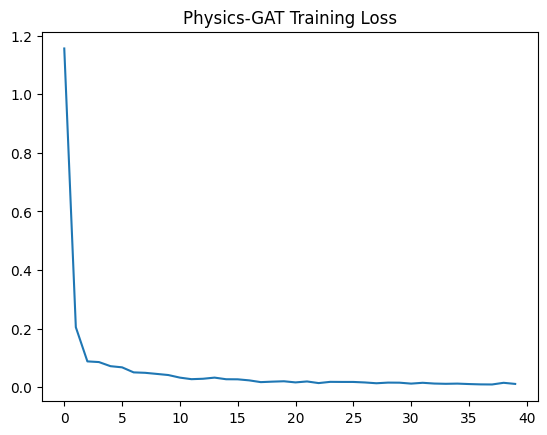

In [6]:
# [Cell 3] 重训模型
print("🚀 开始重训物理增强模型...")

model = PhysicsGAT_DenoiseNet(input_dim=3, edge_dim=2, hidden_dim=CONFIG['hidden_dim'], heads=CONFIG['heads']).to(device)
scheduler = CosineNoiseScheduler(CONFIG['timesteps']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-5)

model.train()
loss_history = []

for epoch in tqdm(range(CONFIG['epochs']), desc="Physics Training"):
    indices = torch.randint(0, num_samples, (BATCH_SIZE,), device=device)
    batch_cond = all_x_tensor[indices].view(-1, 2)
    batch_x0 = all_y_tensor[indices].view(-1, 1)
    
    t = torch.randint(0, CONFIG['timesteps'], (BATCH_SIZE,), device=device)
    ts_nodes = t[static_batch_idx]
    xt, noise = scheduler.add_noise(batch_x0, ts_nodes)
    
    model_input = torch.cat([xt, batch_cond], dim=-1)
    
    # 传入 edge_attr !
    noise_pred = model.forward_with_time_expand(
        x=model_input, 
        t=t, 
        batch_index=static_batch_idx, 
        edge_index=static_edge_index, 
        edge_attr=static_edge_attr
    )
    
    loss = F.mse_loss(noise_pred, noise)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    lr_scheduler.step()
    
    if epoch % 50 == 0:
        loss_history.append(loss.item())

torch.save(model.state_dict(), "../models/gnn_diffusion_ieee33_physics.pth")
plt.plot(loss_history)
plt.title("Physics-GAT Training Loss")
plt.show()

In [7]:
# [Cell 4] 准备 Exp 2 新拓扑与物理参数

# 1. 获取新拓扑的物理参数
def get_new_topology_data():
    net = pn.case33bw()
    # 闭合 8-21 (添加新线)
    pp.create_line(net, 8, 21, length_km=2.0, std_type="NAYY 4x150 SE")
    # 断开 6-7
    line_idx = net.line[(net.line.from_bus == 6) & (net.line.to_bus == 7)].index
    net.line.loc[line_idx, 'in_service'] = False
    
    # 只提取 in_service 的线
    active_lines = net.line[net.line.in_service == True]
    
    r = active_lines.r_ohm_per_km.values * active_lines.length_km.values
    x = active_lines.x_ohm_per_km.values * active_lines.length_km.values
    from_bus = active_lines.from_bus.values
    to_bus = active_lines.to_bus.values
    
    # 构建双向
    attr = np.stack([r, x], axis=1)
    attr_bi = np.concatenate([attr, attr], axis=0)
    src = np.concatenate([from_bus, to_bus])
    dst = np.concatenate([to_bus, from_bus])
    
    # 归一化 (必须用训练集的均值方差！)
    mean, std = edge_stats
    attr_norm = (attr_bi - mean) / (std + 1e-6)
    
    new_edge_index = torch.tensor(np.stack([src, dst]), dtype=torch.long).to(device)
    new_edge_attr = torch.tensor(attr_norm, dtype=torch.float32).to(device)
    
    return new_edge_index, new_edge_attr, net

edge_index_new, edge_attr_new, net_new = get_new_topology_data()
print(f"✅ 新拓扑物理参数提取完成。边数: {edge_index_new.shape[1]}")

# 2. 生成测试数据 (Ground Truth)
print("生成测试数据...")
V_list, P_list, Q_list = [], [], []
base_load_p = net_new.load.p_mw.values.copy()
base_load_q = net_new.load.q_mvar.values.copy()
for _ in range(200):
    load_scale = np.random.uniform(0.8, 1.2)
    net_new.load.p_mw = base_load_p * load_scale
    net_new.load.q_mvar = base_load_q * load_scale
    try:
        pp.runpp(net_new)
        V_list.append(net_new.res_bus.vm_pu.values.copy())
        p_net = np.zeros(33); np.add.at(p_net, net_new.load.bus.values, -net_new.load.p_mw.values)
        q_net = np.zeros(33); np.add.at(q_net, net_new.load.bus.values, -net_new.load.q_mvar.values)
        P_list.append(p_net); Q_list.append(q_net)
    except: continue

V_new = np.array(V_list)
P_new = np.array(P_list); Q_new = np.array(Q_list)

v_min, v_max = stats['v_min'], stats['v_max']
p_mean, p_std = stats['p_mean'], stats['p_std']
q_mean, q_std = stats['q_mean'], stats['q_std']

V_norm = 2 * (V_new - v_min) / (v_max - v_min) - 1
P_norm = (P_new - p_mean) / (p_std + 1e-6)
Q_norm = (Q_new - q_mean) / (q_std + 1e-6)

X_test = torch.tensor(np.stack([P_norm, Q_norm], axis=2), dtype=torch.float32).to(device)
Y_test = torch.tensor(V_norm, dtype=torch.float32).unsqueeze(-1).to(device)

✅ 新拓扑物理参数提取完成。边数: 64
生成测试数据...


Adapting: 0it [00:00, ?it/s]

🎉 Physics-Enhanced Zero-Shot RMSE: 0.0147


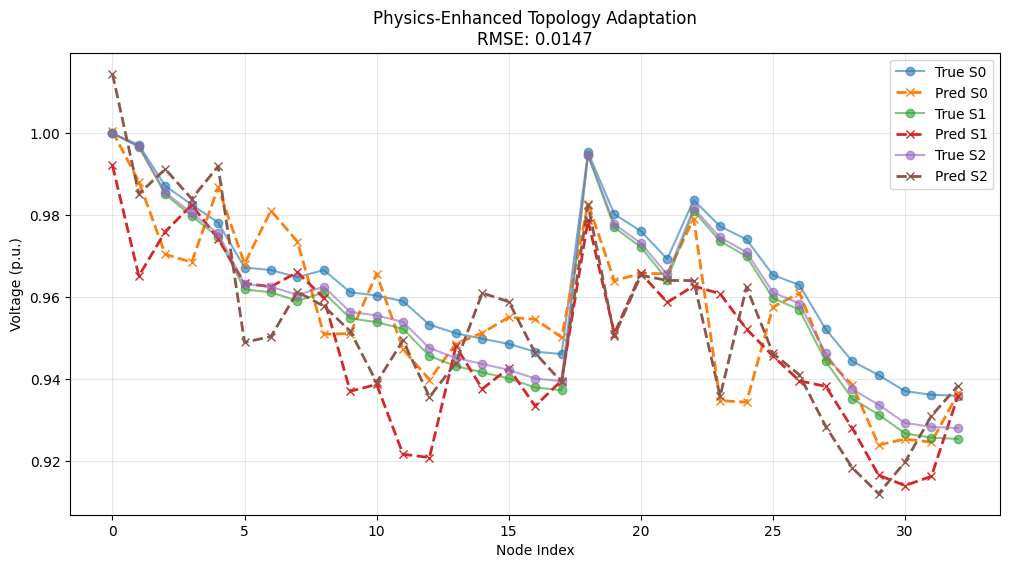

In [8]:
# [Cell 5] Inference

test_batch_size = len(X_test)
# 构建新拓扑的 Batch
static_edge_index_new, static_edge_attr_new, static_batch_idx_new = create_static_batch_topology_with_attr(
    test_batch_size, edge_index_new, edge_attr_new
)

model.eval()
x = torch.randn(test_batch_size * 33, 1, device=device)

with torch.no_grad():
    for i in tqdm(reversed(range(CONFIG['timesteps'])), desc="Adapting"):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        t_batch = t.repeat(test_batch_size)
        
        model_input = torch.cat([x, X_test.view(-1, 2)], dim=-1)
        
        pred_noise = model.forward_with_time_expand(
            x=model_input, t=t_batch, 
            batch_index=static_batch_idx_new, 
            edge_index=static_edge_index_new,
            edge_attr=static_edge_attr_new # 传入新阻抗！
        )
        
        alpha = scheduler.alphas_cumprod[i]
        beta = scheduler.betas[i]
        sqrt_1_minus_alpha = scheduler.sqrt_one_minus_alphas_cumprod[i]
        
        mean = (1 / torch.sqrt(1 - beta)) * (x - (beta / sqrt_1_minus_alpha) * pred_noise)
        mean = torch.clamp(mean, -3.0, 3.0)
        
        if i > 0: x = mean + torch.sqrt(beta) * torch.randn_like(x)
        else: x = mean

gen_v = (x.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min
gt_v = (Y_test.cpu().numpy().flatten() + 1) / 2 * (v_max - v_min) + v_min

rmse = np.sqrt(np.mean((gen_v - gt_v)**2))
print(f"🎉 Physics-Enhanced Zero-Shot RMSE: {rmse:.4f}")

# 绘图
plt.figure(figsize=(12, 6))
for i in range(3):
    s, e = i*33, (i+1)*33
    plt.plot(gt_v[s:e], 'o-', label=f'True S{i}', alpha=0.6)
    plt.plot(gen_v[s:e], 'x--', label=f'Pred S{i}', linewidth=2)

plt.title(f"Physics-Enhanced Topology Adaptation\nRMSE: {rmse:.4f}")
plt.xlabel("Node Index")
plt.ylabel("Voltage (p.u.)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()